Download labels from: http://www.tamaraberg.com/street2shop/wheretobuyit/  
Paper: http://www.cs.unc.edu/~xufeng/cs/papers/iccv15-wheretobuyit.pdf

This dataset contains exact street2shop pairs and the retrieval sets for 11 clothing categories: bags, belts, dresses, eyewear, footwear, hats, leggings, outerwear, pants, skirts, tops

"To study Exact Street to Shop at large scale, we collected and labeled a dataset of 20,357 images of clothing worn by
people in the real world,  and 404,483 images of clothing from shopping websites.  The dataset contains 39,479 pairs
of exactly matching items worn in street photos and shown in shop images."  
  
  
*M. Hadi Kiapour, Xufeng Han, Svetlana Lazebnik, Alexander C. Berg, Tamara L. Berg. Where to Buy It: Matching Street Clothing Photos in Online Shops. International Conference on Computer Vision (ICCV), 2015.*

## Considerations
- Only female clothes dataset
- Retrieval images refer to the website/store images, the train & test files are the user images
- Some user images match more than 1 product ie. shoes + dress + bag in the same photo
- Some items in the user images are heavily duplicated #customer_df[customer_df["product"] == 7182] returns 285 images of the same item
- Some labels in the user images dataframe are duplicates but they have more than 1 bboxes because the same piece of clothe appears >1 on the image
- Retrieval images are usually repeated in different angles, distances, etc. but not always. Only ~200k unique items.
- Original product ids start at 1 for every category, there is not a unique identifier
- To find matches a combination of product id + category is used, however there may be many matches, there could be different customer photos of the same product and category and there will likely be more than 1 photo of the same product and category on the store

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('seaborn')

Files are separated into 3 classes: retrieval, train and test. Each of these classes have a json for each of the 11 clothing categories.  

The function below merges all categories json files under the 3 classes, then train and test are also merged so we can do a custom data split.

In [92]:
path_labels = "./meta/json"
def format_labels(path_labels, shop_images=False):
    
    json_files = os.listdir(path_labels)
    json_files = [os.path.join(path_labels, file) for file in json_files] #reading in all json files
    if shop_images==False:
        all_files = [file for file in json_files if "retrieval" in file]
    else:
        all_files = [file for file in json_files if ("train" in file) | ("test" in file)]
    
    files_df = pd.DataFrame()
    for file in all_files:
        files_df = files_df.append(pd.read_json(file))
    
    category_files = [file.split("_")[-1].split(".json")[0] for file in all_files]
    print("Categories: ", category_files)

    category_nrows = [pd.read_json(file).shape[0] for file in all_files]
    print("Categories number of rows: ", category_nrows)
    
    files_df["category"] = ""
    for n, category in enumerate(category_files):
        if n == 0:
            files_df["category"].iloc[0:category_nrows[0]] = category
        index_0 = sum(category_nrows[:n])
        index_1 = sum(category_nrows[:n+1])
        files_df["category"].iloc[index_0:index_1] = category
    files_df = files_df.reset_index(drop=True)
    
    files_df["id"] = files_df["product"].astype(str) + "_" + files_df["category"] #creating key for pair matching
    
    if shop_images == True:
        files_df["bbox"] = files_df["bbox"].apply(lambda x: {k:v for k, v in sorted(x.items())}) #fixes missalignment in label order
        files_df["bbox"] = files_df["bbox"].apply(lambda x: "".join(map(lambda x: str(x) + ",", list(x.values()))))

        bboxes = files_df["bbox"].str.split(",",expand=True).drop(columns=[4])
        bboxes.columns=(["height", "left", "top", "width"])
        files_df = pd.concat([files_df,bboxes], axis=1).drop(columns=["bbox"])
        return files_df
    return files_df

In [93]:
retrieval_df = format_labels(path_labels)
customer_df = format_labels(path_labels, shop_images=True)

Categories:  ['bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops']
Categories number of rows:  [16319, 1252, 169941, 1595, 75853, 2551, 8228, 34744, 7641, 18295, 68478]


C:\Users\heret\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Categories:  ['bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops', 'bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops']
Categories number of rows:  [174, 89, 3292, 138, 2178, 86, 517, 666, 130, 604, 763, 579, 235, 12875, 358, 6486, 400, 1641, 1945, 600, 3337, 2173]


C:\Users\heret\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
def plot_freqs(df):
    f = plt.figure(figsize=(8,4))
    print(df["category"].value_counts().sort_values(ascending=False))
    df["category"].value_counts().sort_values(ascending=True).plot(
        kind="barh",
        title="Images"
        )
    plt.show()

### Customer data summary

In [199]:
print("Number of photos: ", customer_df.shape[0])
print(customer_df.head(3))
print("Max unique photo times repeated: ", customer_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max unique product times repeated: ", customer_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", customer_df["photo"].unique().shape[0])
print("Unique products: ", customer_df["product"].unique().shape[0])

Number of photos:  39266
   photo  product category          id height left  top width
0   4534     7419     bags   7419_bags    358  134  172   120
1  16159     9946     bags   9946_bags    303  148  184   120
2   6538    10777     bags  10777_bags     88  100  310    57
Max unique photo times repeated:  15
Max unique product times repeated:  285
Unique photos:  20357
Unique products:  9529


In [17]:
print(customer_df.drop_duplicates(subset=["product", "category", "photo"]).shape) #11k = duplicate bboxes
print(customer_df.drop_duplicates(subset=["id"]).shape) #(29k - 11k) = duplicate items with diff pics
#these last dups. should be fine as the photos are different, however the retrieval pair photos they match to will bias the outcome of the match.

(28231, 8)
(10350, 8)


dresses      16167
footwear      8664
skirts        3941
tops          2936
outerwear     2611
leggings      2158
bags           753
pants          730
eyewear        496
hats           486
belts          324
Name: category, dtype: int64


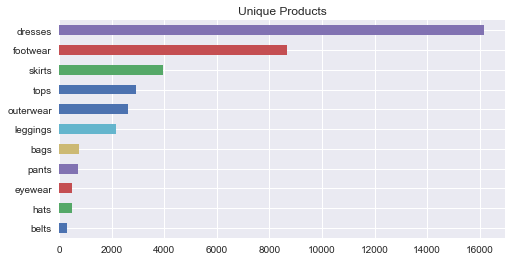

In [7]:
plot_freqs(customer_df)

### Retrieval data summary

In [8]:
print(retrieval_df.shape)
print(retrieval_df.head(3))
print("Max photo times repeated: ", retrieval_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max product times repeated: ", retrieval_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", retrieval_df["photo"].unique().shape[0])
print("Unique products: ", retrieval_df["product"].unique().shape[0])

(404897, 3)
    photo  product category
0   75161        1     bags
1   75162        1     bags
2  249331        2     bags
Max photo times repeated:  4
Max product times repeated:  455
Unique photos:  404483
Unique products:  67606


In [202]:
print(retrieval_df.drop_duplicates(subset=["id"]).shape)
#about half images have duplicates which are photos from the same item in different angles, zooms, etc.
#not every store item have more than 1 photo

(204795, 4)


In [94]:
#to simplify things, removed all duplicates of photo ids with different category (~500).
retrieval_df = retrieval_df.drop_duplicates(subset=["photo"])
print("Unique photos: ", retrieval_df.shape)

Unique photos:  (404483, 4)


dresses      169733
footwear      75836
tops          68390
outerwear     34686
skirts        18280
bags          16308
leggings       8219
pants          7633
hats           2551
eyewear        1595
belts          1252
Name: category, dtype: int64


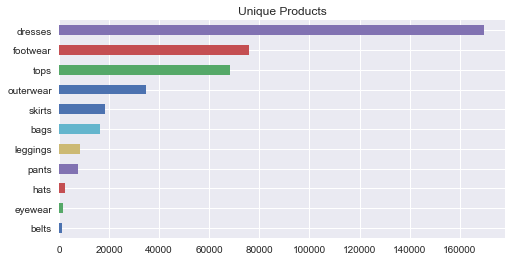

In [10]:
plot_freqs(retrieval_df)

### Example how to find pair matches:
I want to find the shop pair for user image "1.jpg"

In [192]:
#we index by its name on the customer df
customer_df[customer_df["photo"] == 1]
#2 results, we are interested in the dress

,photo,product,category,id,height,left,top,width
2483,1,65901,dresses,65901_dresses,1121,560,143,755
28479,1,14177,footwear,14177_footwear,375,661,1550,445


In [194]:
#we need to look on the store data for the same id of the dress category
retrieval_df[(retrieval_df["id"] == "65901_dresses")]
#we get more than one photo because is the same product from different angles, zooms, etc

,photo,product,category,id
183299,62650,65901,dresses,65901_dresses
183300,62651,65901,dresses,65901_dresses
183301,62652,65901,dresses,65901_dresses
183302,62653,65901,dresses,65901_dresses
183303,62654,65901,dresses,65901_dresses


In [43]:
#needs revisiting to simplify it if finally using this function
def show_image(img_path, bbox=False):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(mpimg.imread(img_path))
    ax.axis("off")
    
    if bbox == True: #xy = (left, top) 
        img_id = img_path.split("/")[-1].split(".")[0]
        img_data = customer_df[customer_df["photo"] == int(img_id)]
        
        if img_data["category"].unique().shape[0] > 1: #could have either more than 1 category or same category with different bboxes
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        if img_data.shape[0] > 1: #if image have more than 1 bbox this will plot all of them
            for index, row in img_data.iterrows():
                top = int(row["top"])
                left = int(row["left"])
                width = int(row["width"])
                height = int(row["height"])

                rect = patches.Rectangle(
                    xy=(left,top),
                    width=width,
                    height=height,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
            plt.show()
            return 
            
        top = int(img_data["top"].values)
        left = int(img_data["left"].values)
        width = int(img_data["width"].values)
        height = int(img_data["height"].values)
        
        rect = patches.Rectangle(
            xy=(left,top),
            width=width,
            height=height,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        plt.show()

Categories:  ['dresses', 'footwear']
Please specify category: dresses


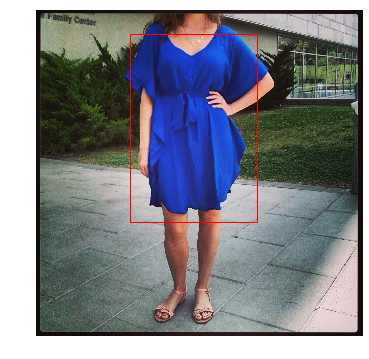

In [239]:
show_image("./photos/1.jpg", bbox=True)

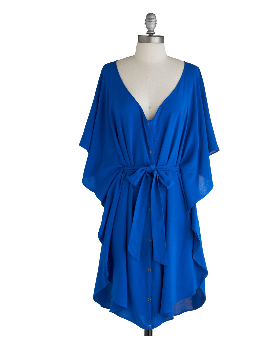

In [222]:
show_image("./photos/62650.jpg")

### How do the missing images affect the dataset?

In [95]:
missing_images = pd.read_csv("./missing_images.csv")
missing_images.drop(columns=["url"],inplace=True)

In [96]:
cust_set = set(customer_df["photo"].tolist()) 
missing_set = set(missing_images["photo"].tolist())
retrieval_set = set(retrieval_df["photo"].tolist()) 

In [97]:
missing_cust = list(cust_set.intersection(missing_set))
print("Customer images missing: ", len(missing_cust))
missing_cust

missing_retrieval = list(retrieval_set.intersection(missing_set))
print("Retrieval images missing: ", len(missing_retrieval))

Customer images missing:  3
Retrieval images missing:  43054


### How do the missing images affect the retrieval data?

dresses      149434
footwear      71950
tops          60888
outerwear     29722
skirts        16536
bags          14586
leggings       6736
pants          6630
hats           2342
eyewear        1460
belts          1145
Name: category, dtype: int64


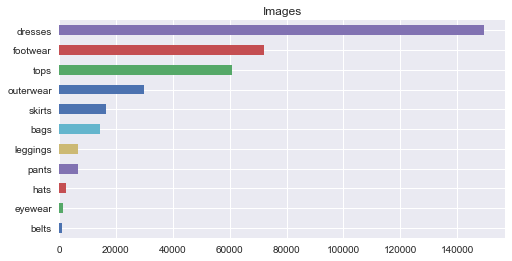

In [98]:
retrieval_available = retrieval_df[~retrieval_df["photo"].isin(missing_retrieval)]
plot_freqs(retrieval_available)

### How do these missing images affect the pair matches?

### Total pair matches

In [209]:
print("Total customer images: ", customer_df.shape[0])
print("Total matches: ", customer_df[customer_df["id"].isin(retrieval_df["id"].tolist())].shape[0])

Total customer images:  39266
Total matches:  39266


dresses      16167
footwear      8664
skirts        3941
tops          2936
outerwear     2611
leggings      2158
bags           753
pants          730
eyewear        496
hats           486
belts          324
Name: category, dtype: int64


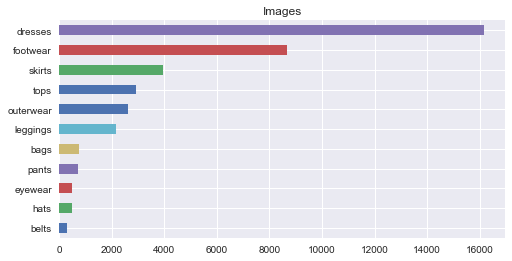

In [215]:
plot_freqs(customer_df[customer_df["id"].isin(retrieval_df["id"].tolist())])

### Available pair matches

In [99]:
print("Total customer images: ", customer_df.shape[0])
customer_available = customer_df[customer_df["id"].isin(retrieval_available["id"].tolist())]
print("Total matches: ", customer_available.shape[0])

Total customer images:  39266
Total matches:  30533


dresses      13480
footwear      7262
tops          2475
skirts        2417
leggings      1736
outerwear     1254
bags           597
pants          478
hats           359
eyewear        290
belts          185
Name: category, dtype: int64


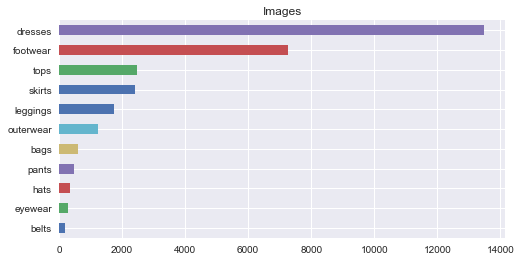

In [212]:
plot_freqs(customer_available)

## Resizing

In [12]:
#resizing fixed to width 300 and same aspect ratio due to having high variability in current img size
#https://stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio
def image_resize(dataset_path, output_path, width=300):
    aspect_ratio = pd.DataFrame()
    
    with tqdm(total=len(os.listdir(dataset_path)), file=sys.stdout) as pbar:
        for n, img_ in enumerate(os.listdir(dataset_path)):
            try:
                img_path = os.path.join(dataset_path, img_)
                img_object = Image.open(img_path)
                img_object = img_object.convert("RGB") #exception with transparent channel, see https://stackoverflow.com/questions/48248405/cannot-write-mode-rgba-as-jpeg

                width_percent = (width/float(img_object.size[0]))
                height_size = int((float(img_object.size[1])*float(width_percent)))
                img_object = img_object.resize((width,height_size), Image.ANTIALIAS)

                output_img = os.path.join(output_path, img_)
                img_object.save(output_img)

                pbar.set_description("images: %d" % (1 + n))
                pbar.update(1)

                aspect_ratio = aspect_ratio.append({"ratio": width_percent, "img": img_}, ignore_index=True)
            except OSError: #corrupted images will break it
                aspect_ratio = aspect_ratio.append({"ratio": "corrupted", "img": img_}, ignore_index=True)
    aspect_ratio.to_csv("aspect_ratios.csv", index=False)

This is estimated to take ~5 hours for 200k images

In [13]:
%%time
image_resize("./photos", "./photos_resized") #some images are not updating the bar since they fall on the exception bucket

C:\Users\heret\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\heret\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (109820000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\Users\heret\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)



Wall time: 5h 54min 27s


Bounding boxes can easily be resized by reverting the transformation to the coordinates. For example, on image 10001 it will resize the height by 0.46875 (300 new width / 640 current width) this means that we also need to shrink the bbox coordinates to 0.46875 of the current values.  

To do this a csv file is created every time the function is run. Then this csv file can be joined to the customer dataframe to update the bbox coordinates.

In [100]:
aspect_ratios = pd.read_csv("./aspect_ratios.csv")
aspect_ratios["img"] = aspect_ratios["img"].str.extract("(\d*)")
aspect_ratios["img"] = aspect_ratios["img"].astype(int)

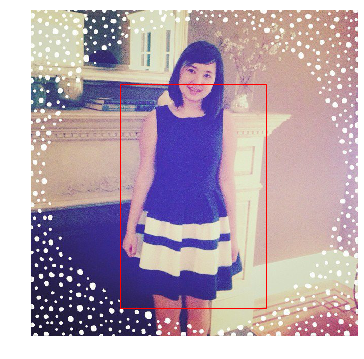

In [47]:
#before resizing
show_image("./photos/10001.jpg", bbox=True)

In [102]:
customer_df = customer_df.merge(aspect_ratios, how="inner", left_on="photo",right_on="img").drop(columns=["img"])

In [103]:
print("Total corrupted photos: ", aspect_ratios[aspect_ratios["ratio"] == "corrupted"].shape[0])

Total corrupted photos:  2542


In [104]:
customer_df = customer_df[customer_df["ratio"] != "corrupted"]
# removing corrupted from the labels

In [105]:
customer_df[["height", "left", "top", "width", "ratio"]] = customer_df[["height", "left", "top", "width", "ratio"]].astype(float)

In [106]:
customer_df["height"] = customer_df["height"]*customer_df["ratio"]
customer_df["left"] = customer_df["left"]*customer_df["ratio"]
customer_df["top"] = customer_df["top"]*customer_df["ratio"]
customer_df["width"] = customer_df["width"]*customer_df["ratio"]

In [107]:
customer_df[["height", "left", "top", "width"]] = customer_df[["height", "left", "top", "width"]].astype(int)

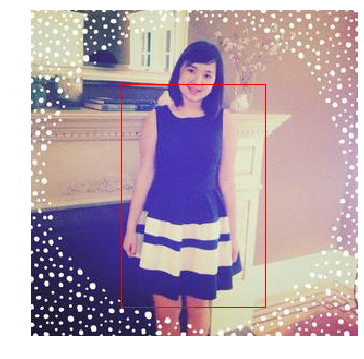

In [143]:
#after resizing
show_image("./photos_resized/10001.jpg", bbox=True)

## Removing all broken links, corrupted and not available images
Corrupted images have just been removed from the customer df.  
This will be revisited if the dataset is completed.

In [109]:
all_missing = pd.read_csv("./missing_images.csv")
all_missing.shape

(43072, 2)

In [110]:
customer_df = customer_df[~customer_df["photo"].isin(all_missing["photo"])]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(all_missing["photo"])]

Removing customer images that do not have a pair match since their actual matches may have been removed now

In [111]:
print("Total customer images: ", customer_df.shape[0])
customer_available = customer_df[customer_df["id"].isin(retrieval_df["id"])]
print("Total matches: ", customer_available.shape[0])

Total customer images:  39261
Total matches:  30528


In [115]:
customer_available = customer_available.drop(columns=["ratio"])

In [116]:
retrieval_df.to_csv("retrieval_df.csv", index=False)
customer_available.to_csv("customer_df.csv", index=False)